In [1]:
import os
import numpy as np
import mne
from mne.filter import notch_filter, filter_data
from scipy.signal import stft
from skimage.transform import resize
from sklearn.utils import shuffle

def common_average_reference(data):
    return data - np.mean(data, axis=0, keepdims=True)

def min_max_normalize(channel_data):
    return (channel_data - np.min(channel_data)) / (np.max(channel_data) - np.min(channel_data) + 1e-6)

def sliding_window_segments(data, window_size, step):
    return np.array([
        data[:, start:start+window_size]
        for start in range(0, data.shape[1] - window_size + 1, step)
    ])

def stft_spectrogram(segment, fs=250, window_size=64, overlap=50):
    f, t, Zxx = stft(segment, fs=fs, window='hann', nperseg=window_size, noverlap=overlap)
    return f, t, np.abs(Zxx)

def extract_band_spectrogram(Sxx, f, band_low, band_high):
    idx = np.where((f >= band_low) & (f <= band_high))[0]
    return Sxx[idx, :]

def resize_spectrogram(spec, target_shape=(20, 32)):
    return resize(spec, target_shape, mode='reflect', anti_aliasing=True)

def get_true_subject_id(filename):
    """
    Extracts subject number from filename like B0203T.gdf -> subject 1
    """
    subject_number = int(filename[1:3])
    return subject_number - 1  # zero-indexed subject ID

def preprocess_gdf_folder_stft_v2(
        folder_path,
        selected_channels=['c3', 'cz', 'c4'],
        fs=250,
        trial_window_sec=4,
        sliding_window_sec=2,
        sliding_step_sec=0.1,
        stft_window=64,
        stft_overlap=50,
        add_gaussian_noise=False):

    X, y, subject_ids = [], [], []

    trial_window_samples = int(trial_window_sec * fs)
    sliding_window_samples = int(sliding_window_sec * fs)
    sliding_step_samples = int(sliding_step_sec * fs)

    event_code_to_label = {769: 0, 770: 1}  # Left, Right

    for filename in sorted(os.listdir(folder_path)):
        if not filename.endswith('.gdf'):
            continue

        filepath = os.path.join(folder_path, filename)
        subject_id = get_true_subject_id(filename)

        try:
            with mne.utils.use_log_level('ERROR'):
                raw = mne.io.read_raw_gdf(filepath, preload=True)
        except Exception as e:
            print(f"❌ Failed to load {filename}: {e}")
            continue

        print(f"📄 Processing {filename} (Subject {subject_id})")

        data = raw.get_data()
        channel_names = raw.info['ch_names']
        cleaned_names = [ch.lower().replace('eeg:', '').replace('eeg-', '').strip() for ch in channel_names]

        try:
            idx = [cleaned_names.index(ch.lower()) for ch in selected_channels]
        except ValueError as e:
            print(f"⚠ Skipping {filename} due to missing channels: {e}")
            continue

        data_sel = data[idx, :]

        # --- Filters ---
        data_car = common_average_reference(data_sel)
        with mne.utils.use_log_level('WARNING'):
            data_notch = notch_filter(data_car, fs, freqs=50, method='fir')
            data_band = filter_data(data_notch, fs, l_freq=8, h_freq=30, method='fir',
                                    phase='zero-double', fir_window='hamming')

        data_norm = np.array([min_max_normalize(ch) for ch in data_band])

        annotations = raw.annotations
        event_onsets = annotations.onset
        event_descriptions = annotations.description
        artifact_times = [int((onset + 3) * fs) for onset, desc in zip(event_onsets, event_descriptions) if desc == '1023']

        for onset, desc in zip(event_onsets, event_descriptions):
            try:
                code = int(desc.strip())
            except:
                continue

            if code not in event_code_to_label:
                continue

            label = event_code_to_label[code]
            start_sample = int((onset + 3) * fs)
            end_sample = start_sample + trial_window_samples

            if any(abs(start_sample - a) < trial_window_samples for a in artifact_times):
                continue
            if end_sample > data_norm.shape[1]:
                continue

            trial = data_norm[:, start_sample:end_sample]
            segments = sliding_window_segments(trial, sliding_window_samples, sliding_step_samples)

            for segment in segments:
                channel_imgs = []
                for ch in range(len(selected_channels)):
                    sig = segment[ch, :]
                    f, t, Sxx = stft_spectrogram(sig, fs=fs, window_size=stft_window, overlap=stft_overlap)

                    mu_spec = extract_band_spectrogram(Sxx, f, 8, 14)
                    mu_resized = resize_spectrogram(mu_spec)

                    beta_spec = extract_band_spectrogram(Sxx, f, 16, 30)
                    beta_resized = resize_spectrogram(beta_spec)

                    combined_spec = np.vstack([mu_resized, beta_resized])  # (40, 32)
                    channel_imgs.append(combined_spec)

                img = np.vstack(channel_imgs)  # (120, 32)
                img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)  # (120, 32, 3)

                if add_gaussian_noise:
                    noise = np.random.normal(0, 0.01, img.shape)
                    img += noise

                img = (img - np.mean(img)) / (np.std(img) + 1e-6)

                X.append(img)
                y.append(label)
                subject_ids.append(subject_id)  # ✅ track correct subject ID

    # Final arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    subject_ids = np.array(subject_ids, dtype=np.int64)

    # Shuffle all together
    X, y, subject_ids = shuffle(X, y, subject_ids, random_state=42)

    print(f"\n✅ Done. Generated {len(X)} samples from {len(np.unique(subject_ids))} subjects.")
    print(f"🟢 X shape: {X.shape}, y shape: {y.shape}, subject_ids shape: {subject_ids.shape}")
    return X, y, subject_ids


In [2]:
X, y, subject_ids = preprocess_gdf_folder_stft_v2('data/GDF file/2b_train')

np.save('X_preprocessed.npy', X)
np.save('y_preprocessed.npy', y)
np.save('subject_ids.npy', subject_ids)


📄 Processing B0101T.gdf (Subject 0)
📄 Processing B0102T.gdf (Subject 0)
📄 Processing B0103T.gdf (Subject 0)
📄 Processing B0201T.gdf (Subject 1)
📄 Processing B0202T.gdf (Subject 1)
📄 Processing B0203T.gdf (Subject 1)
📄 Processing B0301T.gdf (Subject 2)
📄 Processing B0302T.gdf (Subject 2)
📄 Processing B0303T.gdf (Subject 2)
📄 Processing B0401T.gdf (Subject 3)
📄 Processing B0402T.gdf (Subject 3)
📄 Processing B0403T.gdf (Subject 3)
📄 Processing B0501T.gdf (Subject 4)
📄 Processing B0502T.gdf (Subject 4)
📄 Processing B0503T.gdf (Subject 4)
📄 Processing B0601T.gdf (Subject 5)
📄 Processing B0602T.gdf (Subject 5)
📄 Processing B0603T.gdf (Subject 5)
📄 Processing B0701T.gdf (Subject 6)
📄 Processing B0702T.gdf (Subject 6)
📄 Processing B0703T.gdf (Subject 6)
📄 Processing B0801T.gdf (Subject 7)
📄 Processing B0802T.gdf (Subject 7)
📄 Processing B0803T.gdf (Subject 7)
📄 Processing B0901T.gdf (Subject 8)
📄 Processing B0902T.gdf (Subject 8)
📄 Processing B0903T.gdf (Subject 8)

✅ Done. Generated 63546 sam

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchsummary import summary

In [4]:
class EnhancedEEGCNNV3(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedEEGCNNV3, self).__init__()

        self.act = nn.SiLU()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.se_fc1 = nn.Linear(256, 64)
        self.se_fc2 = nn.Linear(64, 256)

        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256 * 8 * 2, 256)  # Adjust dims if needed
        self.fc2 = nn.Linear(256, num_classes)

    def se_block(self, x):
        b, c, _, _ = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.act(self.se_fc1(y))
        y = torch.sigmoid(self.se_fc2(y)).view(b, c, 1, 1)
        return x * y

    def forward(self, x):
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.act(self.bn4(self.conv4(x)))
        x = self.se_block(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.fc2(x)
        return x

In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedEEGCNNV3().to(device)
dummy_input = torch.randn(2, 3, 120, 32).to(device)
output = model(dummy_input)
print(output.shape)  # Should be: torch.Size([2, 2])
summary(model, input_size=(3, 120, 32))  # Exclude batch size


NameError: name 'torch' is not defined

In [6]:
def augment_spec(x, time_mask=10, freq_mask=5):
    """Apply random time and frequency masking to a spectrogram."""
    # x: Tensor of shape (C=3, H=120, W=32)
    c, h, w = x.shape
    x_aug = x.clone()

    # Time masking (along H)
    if torch.rand(1).item() < 0.5:
        t_indices = torch.randint(0, h, (time_mask,))
        x_aug[:, t_indices, :] = 0

    # Frequency masking (along W)
    if torch.rand(1).item() < 0.5:
        f_indices = torch.randint(0, w, (freq_mask,))
        x_aug[:, :, f_indices] = 0

    return x_aug

In [7]:
class EEGDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx].astype(np.float32)
        img = (img - img.mean()) / (img.std() + 1e-6)
        img = torch.as_tensor(img).permute(2, 0, 1) # (C, H, W)

        if self.augment:
            img = augment_spec(img)

        label = torch.tensor(self.y[idx]).long()
        return img, label

In [8]:
# ---- Load preprocessed data ----
X = np.load("X_preprocessed.npy")
y = np.load("y_preprocessed.npy")

In [9]:
class LazyEEGDataset(Dataset):
    def __init__(self, X_path, y_path, indices):
        self.X = np.load(X_path, mmap_mode='r')  # Lazy load (memory-mapped)
        self.y = np.load(y_path)[indices]
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        x = self.X[i].transpose(2, 0, 1)  # (C, H, W)
        y = self.y[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

def create_dataloaders_with_test(X_path, y_path, batch_size=16):
    total_indices = np.arange(len(np.load(y_path)))
    y_full = np.load(y_path)

    # Split train+val vs test
    trainval_idx, test_idx = train_test_split(
        total_indices, test_size=0.15, stratify=y_full, random_state=42
    )

    # Split train vs val from trainval
    train_idx, val_idx = train_test_split(
        trainval_idx, test_size=0.176, stratify=y_full[trainval_idx], random_state=42
    )

    # Create datasets with indices
    train_dataset = LazyEEGDataset(X_path, y_path, train_idx)
    val_dataset   = LazyEEGDataset(X_path, y_path, val_idx)
    test_dataset  = LazyEEGDataset(X_path, y_path, test_idx)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader


In [10]:
def evaluate_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    avg_loss = total_loss / len(loader)

    return acc, prec, rec, f1, avg_loss


def train_model(model, train_loader, val_loader, device, epochs=300, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.5)

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        all_preds, all_labels = [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        # Compute training metrics
        train_acc = accuracy_score(all_labels, all_preds)
        train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        train_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        train_loss = total_loss / len(train_loader)

        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Validation
        val_acc, val_prec, val_rec, val_f1, val_loss = evaluate_metrics(model, val_loader, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        # Learning rate adjustment
        prev_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_acc)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr != prev_lr:
            print(f"🔁 LR changed from {prev_lr:.6f} to {new_lr:.6f}")

        # Logging
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss : {train_loss:.4f}")
        print(f"  Train Acc  : {train_acc:.4f}")
        print(f"  Precision  : {train_precision:.4f}")
        print(f"  Recall     : {train_recall:.4f}")
        print(f"  F1 Score   : {train_f1:.4f}")
        print(f"  Val Loss   : {val_loss:.4f}")
        print(f"  Val Acc    : {val_acc:.4f}")
        print(f"  LR         : {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)

    torch.save(model.state_dict(), "cnn_eeg_model.pth")
    print("✅ Model saved as cnn_eeg_model.pth")
    return train_accs, val_accs, train_losses, val_losses


In [11]:
# def evaluate_per_subject(model, X_path, y_path, subject_path, device):
#     X = np.load(X_path, mmap_mode='r')
#     y = np.load(y_path)
#     subject_ids = np.load(subject_path)

#     unique_subjects = np.unique(subject_ids)

#     for subj in unique_subjects:
#         indices = np.where(subject_ids == subj)[0]
#         X_subj = torch.tensor(X[indices].transpose(0, 3, 1, 2), dtype=torch.float32)  # (N, C, H, W)
#         y_subj = torch.tensor(y[indices], dtype=torch.long)

#         model.eval()
#         all_preds = []
#         all_labels = []

#         with torch.no_grad():
#             for i in range(len(X_subj)):
#                 input = X_subj[i].unsqueeze(0).to(device)
#                 label = y_subj[i].unsqueeze(0).to(device)

#                 output = model(input)
#                 _, pred = torch.max(output, 1)

#                 all_preds.extend(pred.cpu().numpy())
#                 all_labels.extend(label.cpu().numpy())

#         acc = accuracy_score(all_labels, all_preds)
#         prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
#         rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
#         f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
#         cm = confusion_matrix(all_labels, all_preds)

#         TP = cm[1, 1] if cm.shape == (2, 2) else 0
#         TN = cm[0, 0] if cm.shape == (2, 2) else 0
#         FP = cm[0, 1] if cm.shape == (2, 2) else 0
#         FN = cm[1, 0] if cm.shape == (2, 2) else 0

#         print(f"\n🎓 Subject {subj} — Evaluation:")
#         print(f"Accuracy       : {acc:.4f}")
#         print(f"Precision      : {prec:.4f}")
#         print(f"Recall         : {rec:.4f}")
#         print(f"F1 Score       : {f1:.4f}")
#         print("Confusion Matrix:\n", cm)
#         print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")


In [12]:
def evaluate_on_test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    print("\n✅ Global Test Evaluation:")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print("Confusion Matrix:\n", cm)
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")


In [ ]:
def evaluate_per_subject(model, X_path, y_path, subject_path, device):
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    import torch.nn as nn

    # Load data
    X = np.load(X_path, mmap_mode='r')
    y = np.load(y_path)
    subject_ids = np.load(subject_path)
    unique_subjects = np.unique(subject_ids)

    criterion = nn.CrossEntropyLoss()

    # store overall metrics + confusion matrices
    all_acc, all_prec, all_rec, all_f1 = [], [], [], []
    cm_sum = None  # to accumulate confusion matrices

    for subj in unique_subjects:
        indices = np.where(subject_ids == subj)[0]
        X_subj = torch.tensor(X[indices].transpose(0, 3, 1, 2), dtype=torch.float32).to(device)
        y_subj = torch.tensor(y[indices], dtype=torch.long).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(X_subj)
            loss = criterion(outputs, y_subj)
            _, preds = torch.max(outputs, 1)

        all_preds = preds.cpu().numpy()
        all_labels = y_subj.cpu().numpy()

        # Metrics
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)

        # Add to running totals
        all_acc.append(acc)
        all_prec.append(prec)
        all_rec.append(rec)
        all_f1.append(f1)
        if cm_sum is None:
            cm_sum = cm.astype(np.float64)
        else:
            cm_sum += cm

        print(f"\n🎓 Subject {subj} — Evaluation:")
        print(f"Loss          : {loss.item():.4f}")
        print(f"Accuracy      : {acc:.4f}")
        print(f"Precision     : {prec:.4f}")
        print(f"Recall        : {rec:.4f}")
        print(f"F1 Score      : {f1:.4f}")
        print("Confusion Matrix:\n", cm)

    # ---- AVERAGE RESULTS ----
    print("\n📊 === Overall Averages Across Subjects ===")
    print(f"Mean Accuracy : {np.mean(all_acc):.4f}")
    print(f"Mean Precision: {np.mean(all_prec):.4f}")
    print(f"Mean Recall   : {np.mean(all_rec):.4f}")
    print(f"Mean F1 Score : {np.mean(all_f1):.4f}")

    # Average confusion matrix
    avg_cm = cm_sum / len(unique_subjects)
    print("\n📊 Average Confusion Matrix (across subjects):\n", avg_cm.astype(int))

    # Plot heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues')
    plt.title("Average Confusion Matrix (All Subjects)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [14]:
def plot_training_curves(train_accuracies, val_accuracies, train_losses, val_losses):
    best_epoch = np.argmax(val_accuracies)
    best_val_acc = val_accuracies[best_epoch]

    plt.figure(figsize=(14, 5))

    # --- Accuracy curve ---
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Acc', marker='o')
    plt.plot(val_accuracies, label='Val Acc', marker='s')
    plt.axvline(best_epoch, linestyle='--', color='gray', label=f'Best Epoch ({best_epoch+1})')

    # Highlight best val acc with an 'x'
    plt.plot(best_epoch, best_val_acc, marker='x', markersize=10, color='red', label=f'Best Val Acc {best_val_acc:.4f}')

    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Loss curve ---
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='s')
    plt.axvline(best_epoch, linestyle='--', color='gray', label=f'Best Epoch ({best_epoch+1})')

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Epoch 1/200
  Train Loss : 0.6880
  Train Acc  : 0.5389
  Precision  : 0.5391
  Recall     : 0.5389
  F1 Score   : 0.5384
  Val Loss   : 0.6769
  Val Acc    : 0.5667
  LR         : 0.001000
--------------------------------------------------
Epoch 2/200
  Train Loss : 0.6773
  Train Acc  : 0.5670
  Precision  : 0.5671
  Recall     : 0.5670
  F1 Score   : 0.5669
  Val Loss   : 0.6716
  Val Acc    : 0.5795
  LR         : 0.001000
--------------------------------------------------
Epoch 3/200
  Train Loss : 0.6689
  Train Acc  : 0.5810
  Precision  : 0.5810
  Recall     : 0.5810
  F1 Score   : 0.5809
  Val Loss   : 0.6618
  Val Acc    : 0.5840
  LR         : 0.001000
--------------------------------------------------
Epoch 4/200
  Train Loss : 0.6591
  Train Acc  : 0.5893
  Precision  : 0.5893
  Recall     : 0.5893
  F1 Score   : 0.5892
  Val Loss   : 0.6508
  Val Acc    : 0.5990
  LR         : 0.001000
--------------------------------------------------
Epoch 5/200
  Train Loss : 0.6455
  

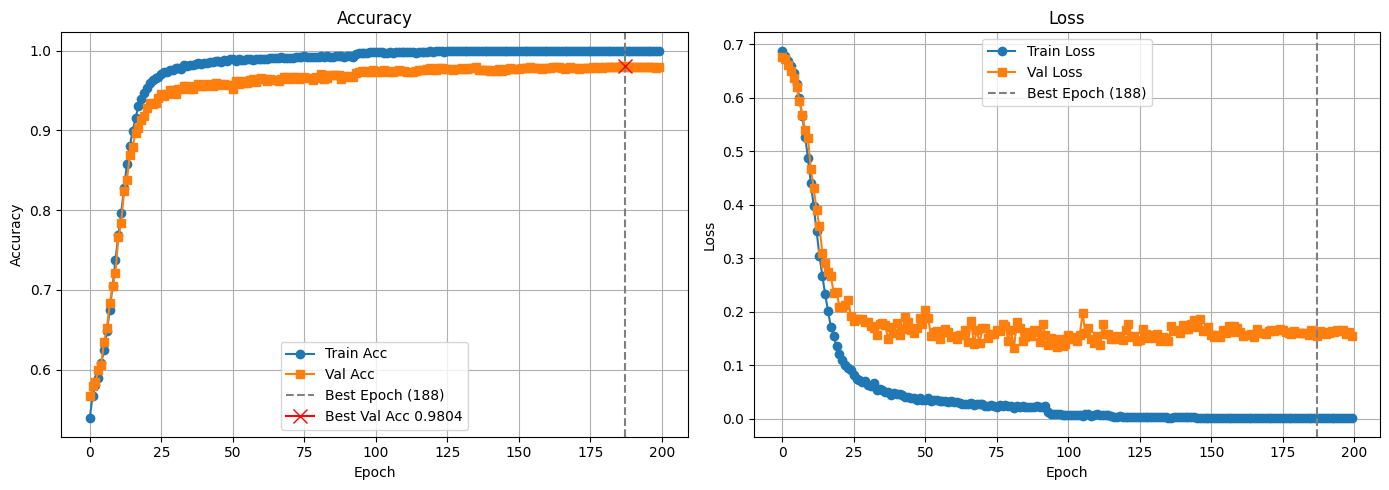


✅ Global Test Evaluation:
Accuracy       : 0.9810
Precision      : 0.9810
Recall         : 0.9810
F1 Score       : 0.9810
Confusion Matrix:
 [[4682   87]
 [  94 4669]]
TP: 4669, TN: 4682, FP: 87, FN: 94

🎓 Subject 0 — Evaluation:
Accuracy       : 0.9932
Precision      : 0.9932
Recall         : 0.9933
F1 Score       : 0.9932
Confusion Matrix:
 [[3324   15]
 [  31 3434]]
TP: 3434, TN: 3324, FP: 15, FN: 31


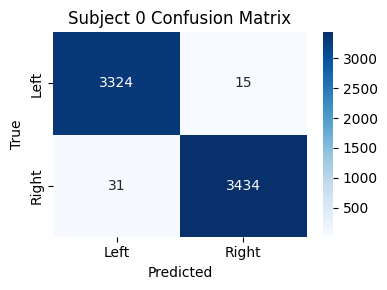


🎓 Subject 1 — Evaluation:
Accuracy       : 0.9931
Precision      : 0.9931
Recall         : 0.9930
F1 Score       : 0.9931
Confusion Matrix:
 [[3391   32]
 [  16 3470]]
TP: 3470, TN: 3391, FP: 32, FN: 16


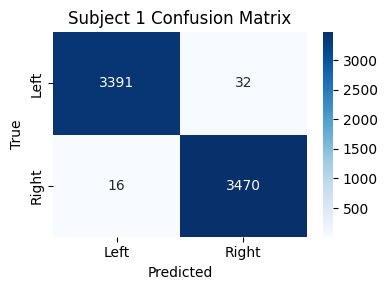


🎓 Subject 2 — Evaluation:
Accuracy       : 0.9942
Precision      : 0.9942
Recall         : 0.9942
F1 Score       : 0.9942
Confusion Matrix:
 [[3050   16]
 [  20 3130]]
TP: 3130, TN: 3050, FP: 16, FN: 20


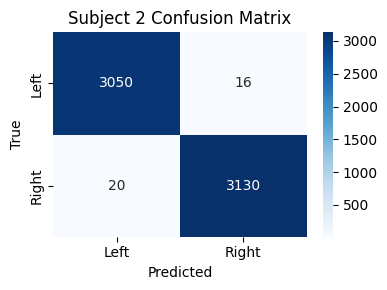


🎓 Subject 3 — Evaluation:
Accuracy       : 0.9955
Precision      : 0.9955
Recall         : 0.9955
F1 Score       : 0.9955
Confusion Matrix:
 [[4203   18]
 [  20 4138]]
TP: 4138, TN: 4203, FP: 18, FN: 20


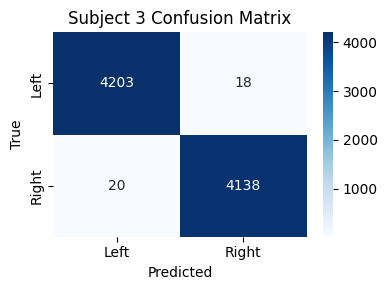


🎓 Subject 4 — Evaluation:
Accuracy       : 0.9920
Precision      : 0.9920
Recall         : 0.9920
F1 Score       : 0.9920
Confusion Matrix:
 [[4028   25]
 [  39 3930]]
TP: 3930, TN: 4028, FP: 25, FN: 39


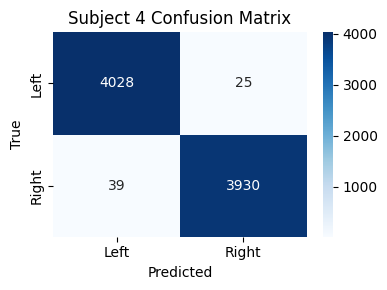


🎓 Subject 5 — Evaluation:
Accuracy       : 0.9968
Precision      : 0.9968
Recall         : 0.9968
F1 Score       : 0.9968
Confusion Matrix:
 [[2972   10]
 [  10 3203]]
TP: 3203, TN: 2972, FP: 10, FN: 10


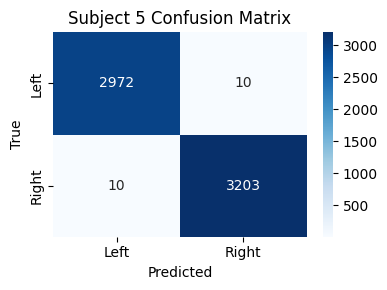


🎓 Subject 6 — Evaluation:
Accuracy       : 0.9953
Precision      : 0.9953
Recall         : 0.9953
F1 Score       : 0.9953
Confusion Matrix:
 [[3722   16]
 [  19 3719]]
TP: 3719, TN: 3722, FP: 16, FN: 19


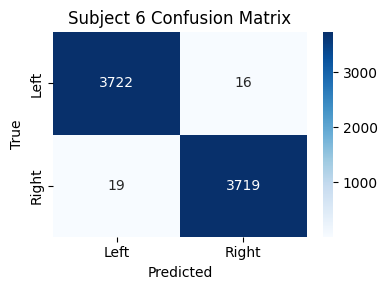


🎓 Subject 7 — Evaluation:
Accuracy       : 0.9925
Precision      : 0.9923
Recall         : 0.9925
F1 Score       : 0.9924
Confusion Matrix:
 [[3643   32]
 [  20 3193]]
TP: 3193, TN: 3643, FP: 32, FN: 20


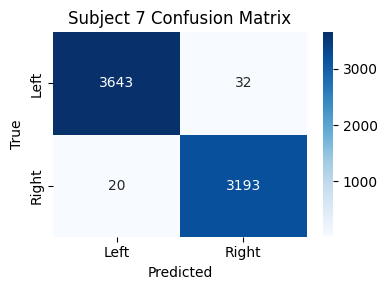


🎓 Subject 8 — Evaluation:
Accuracy       : 0.9938
Precision      : 0.9938
Recall         : 0.9938
F1 Score       : 0.9938
Confusion Matrix:
 [[3279   18]
 [  23 3337]]
TP: 3337, TN: 3279, FP: 18, FN: 23


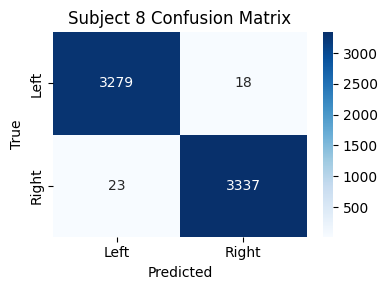

In [15]:
if __name__ == "__main__":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = EnhancedEEGCNNV3().to(device)

    train_loader, val_loader, test_loader = create_dataloaders_with_test(
        'X_preprocessed.npy',
        'y_preprocessed.npy',
        batch_size=16
    )

    train_accs, val_accs, train_losses, val_losses = train_model(
        model, train_loader, val_loader, device, epochs=200
    )

    plot_training_curves(train_accs, val_accs, train_losses, val_losses)

    # ✅ Global test set evaluation
    evaluate_on_test(model, test_loader, device)

    # ✅ Per-subject evaluation with confusion matrix
    evaluate_per_subject(
        model,
        'X_preprocessed.npy',
        'y_preprocessed.npy',
        'subject_ids.npy',
        device
    )



🎓 Subject 0 — Evaluation:
Accuracy       : 0.9932
Precision      : 0.9932
Recall         : 0.9933
F1 Score       : 0.9932
Confusion Matrix:
 [[3324   15]
 [  31 3434]]
TP: 3434, TN: 3324, FP: 15, FN: 31


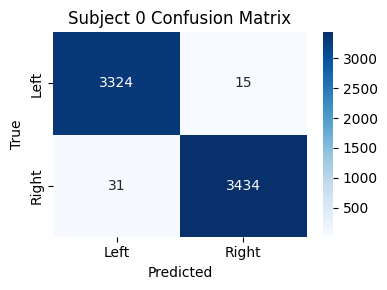


🎓 Subject 1 — Evaluation:
Accuracy       : 0.9931
Precision      : 0.9931
Recall         : 0.9930
F1 Score       : 0.9931
Confusion Matrix:
 [[3391   32]
 [  16 3470]]
TP: 3470, TN: 3391, FP: 32, FN: 16


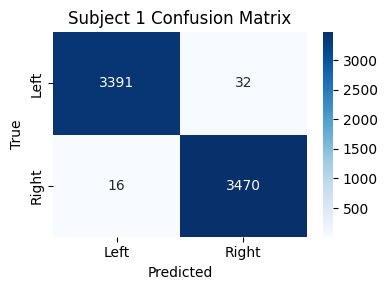


🎓 Subject 2 — Evaluation:
Accuracy       : 0.9942
Precision      : 0.9942
Recall         : 0.9942
F1 Score       : 0.9942
Confusion Matrix:
 [[3050   16]
 [  20 3130]]
TP: 3130, TN: 3050, FP: 16, FN: 20


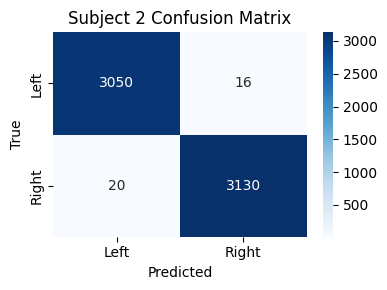


🎓 Subject 3 — Evaluation:
Accuracy       : 0.9955
Precision      : 0.9955
Recall         : 0.9955
F1 Score       : 0.9955
Confusion Matrix:
 [[4203   18]
 [  20 4138]]
TP: 4138, TN: 4203, FP: 18, FN: 20


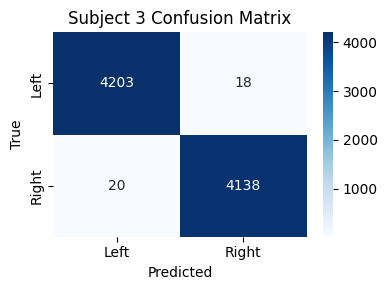


🎓 Subject 4 — Evaluation:
Accuracy       : 0.9920
Precision      : 0.9920
Recall         : 0.9920
F1 Score       : 0.9920
Confusion Matrix:
 [[4028   25]
 [  39 3930]]
TP: 3930, TN: 4028, FP: 25, FN: 39


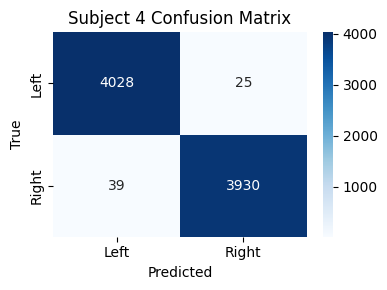


🎓 Subject 5 — Evaluation:
Accuracy       : 0.9968
Precision      : 0.9968
Recall         : 0.9968
F1 Score       : 0.9968
Confusion Matrix:
 [[2972   10]
 [  10 3203]]
TP: 3203, TN: 2972, FP: 10, FN: 10


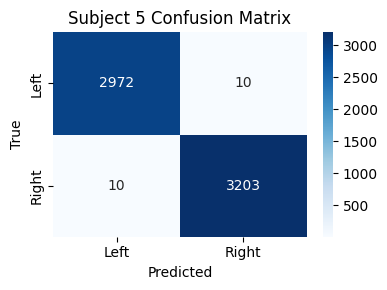


🎓 Subject 6 — Evaluation:
Accuracy       : 0.9953
Precision      : 0.9953
Recall         : 0.9953
F1 Score       : 0.9953
Confusion Matrix:
 [[3722   16]
 [  19 3719]]
TP: 3719, TN: 3722, FP: 16, FN: 19


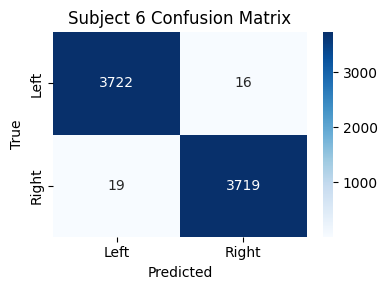


🎓 Subject 7 — Evaluation:
Accuracy       : 0.9925
Precision      : 0.9923
Recall         : 0.9925
F1 Score       : 0.9924
Confusion Matrix:
 [[3643   32]
 [  20 3193]]
TP: 3193, TN: 3643, FP: 32, FN: 20


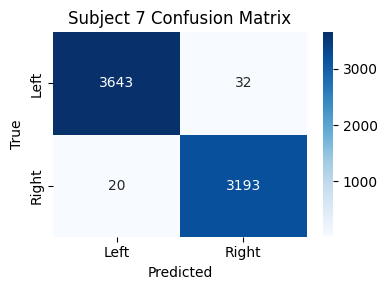


🎓 Subject 8 — Evaluation:
Accuracy       : 0.9938
Precision      : 0.9938
Recall         : 0.9938
F1 Score       : 0.9938
Confusion Matrix:
 [[3279   18]
 [  23 3337]]
TP: 3337, TN: 3279, FP: 18, FN: 23


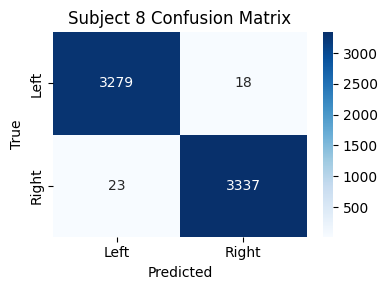

In [16]:
evaluate_per_subject(model,'X_preprocessed.npy','y_preprocessed.npy','subject_ids.npy',device)

In [17]:
import numpy as np
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_and_export_subject_metrics(model, X_path, y_path, subject_path, device,
                                        save_dir="subject_results", plot_confusion=True, save_csv=True):
    os.makedirs(save_dir, exist_ok=True)

    X = np.load(X_path, mmap_mode='r')
    y = np.load(y_path)
    subject_ids = np.load(subject_path)

    unique_subjects = np.unique(subject_ids)
    results = []

    for subj in unique_subjects:
        indices = np.where(subject_ids == subj)[0]
        X_subj = torch.tensor(X[indices].transpose(0, 3, 1, 2), dtype=torch.float32)
        y_subj = torch.tensor(y[indices], dtype=torch.long)

        model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for i in range(len(X_subj)):
                input = X_subj[i].unsqueeze(0).to(device)
                label = y_subj[i].unsqueeze(0).to(device)
                output = model(input)
                _, pred = torch.max(output, 1)

                all_preds.append(pred.item())
                all_labels.append(label.item())

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        cm = confusion_matrix(all_labels, all_preds)

        TP = cm[1, 1] if cm.shape == (2, 2) else 0
        TN = cm[0, 0] if cm.shape == (2, 2) else 0
        FP = cm[0, 1] if cm.shape == (2, 2) else 0
        FN = cm[1, 0] if cm.shape == (2, 2) else 0

        results.append({
            "Subject": subj,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "TP": TP,
            "TN": TN,
            "FP": FP,
            "FN": FN
        })

        print(f"🎓 Subject {subj} done.")

        # 🔵 Save confusion matrix
        if plot_confusion:
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
            plt.title(f"Confusion Matrix - Subject {subj}")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"subject_{subj}_confusion.png"))
            plt.close()

    # ✅ Save CSV
    if save_csv:
        df = pd.DataFrame(results)
        df.to_csv(os.path.join(save_dir, "subject_metrics.csv"), index=False)
        print(f"\n✅ Metrics saved to {save_dir}/subject_metrics.csv")

    # 📊 Plot accuracy per subject
    plt.figure(figsize=(10, 5))
    subjects = [r['Subject'] for r in results]
    accuracies = [r['Accuracy'] for r in results]
    sns.barplot(x=subjects, y=accuracies)
    plt.title("Accuracy per Subject")
    plt.xlabel("Subject ID")
    plt.ylabel("Accuracy")
    plt.ylim(0.98, 1.0)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "accuracy_per_subject.png"))
    plt.close()
    print(f"📊 Accuracy plot saved to {save_dir}/accuracy_per_subject.png")


In [18]:
if __name__ == "__main__":
    # ... training part ...

    # ✅ Evaluate and export per-subject metrics
    evaluate_and_export_subject_metrics(
        model,
        X_path="X_preprocessed.npy",
        y_path="y_preprocessed.npy",
        subject_path="subject_ids.npy",
        device=device,
        save_dir="subject_results",         # all outputs saved here
        plot_confusion=True,                # save PNG confusion matrices
        save_csv=True                       # save to CSV
    )


🎓 Subject 0 done.
🎓 Subject 1 done.
🎓 Subject 2 done.
🎓 Subject 3 done.
🎓 Subject 4 done.
🎓 Subject 5 done.
🎓 Subject 6 done.
🎓 Subject 7 done.
🎓 Subject 8 done.

✅ Metrics saved to subject_results/subject_metrics.csv
📊 Accuracy plot saved to subject_results/accuracy_per_subject.png


In [19]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert to numpy arrays (if using torch tensors)
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

# Compute metrics
acc = accuracy_score(y_true_np, y_pred_np)
precision = precision_score(y_true_np, y_pred_np, average='macro')
recall = recall_score(y_true_np, y_pred_np, average='macro')
f1 = f1_score(y_true_np, y_pred_np, average='macro')
cm = confusion_matrix(y_true_np, y_pred_np)

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print("✅ Confusion Matrix:\n", cm)
print("\n✅ Classification Report:\n", classification_report(y_true_np, y_pred_np))
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Left", "Right"], yticklabels=["Left", "Right"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()



NameError: name 'y_true' is not defined